# ECG Pupillometry Pipeline

### Brain Hack School 2019
### Marcel Kaufmann

# Video Introduction

In [88]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/8ZVCNeX42_A" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')




/Users/kaufmann/anaconda3/envs/bh/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning:

Consider using IPython.display.IFrame instead



* Pupillometry (Pupil Labs Eye Tracker)

<img src="img/pupillometer.png" width=353)> <img src="img/eye.png" width=300)>

* Heart rate and RR intervals (Polar H7 fitness tracker)

![Polar HR Monitor](https://www.polar.com/sites/default/files/product/main_images/h7_heart_rate_sensor2_main_action_30.jpg)

* ECG, EDA from Biopac (as acq files)
<div style="display: flex; justify-content: center;">
<img src="https://www.biopac.com/wp-content/uploads/bsladv-300x300.jpg")>
</div>

# Tools I plan to use / want to learn

* Anaconda
* Docker
* Pandas
* NeuroKit
* Ipython Notebooks

# Imports

In [89]:
#Existing Analysis Packages
import neurokit as nk
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values
from hrvanalysis import get_time_domain_features, plot_psd, plot_distrib
from hrvanalysis import plot_poincare
from hrv.classical import time_domain

#Dynamic Time Warping
from dtwalign import dtw 

#Plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%pylab inline
pylab.rcParams['figure.figsize']= (15,7.0) #creating bigger figure

#Awesome libraries to have..
import numpy as np
import pandas as pd
import scipy
from scipy.signal import butter, lfilter, freqz

Populating the interactive namespace from numpy and matplotlib


# Let's have a look at the data...

In [90]:
fileName='./data/M/2019_07_03_MP_Dep_Run1.txt'
df=pd.read_csv(fileName,header=[15])

In [91]:
df.tail()

CH1      CH2       CH3      CH40   CH41     CH42  Unnamed: 6
301591 -0.918579  1.10535  0.502930 -0.256703  0.706  165.289         NaN
301592 -0.918579  1.11603  0.504150 -0.242343  0.706  165.289         NaN
301593 -0.918579  1.12473  0.505371 -0.230164  0.706  165.289         NaN
301594 -0.920105  1.13190  0.503540 -0.219675  0.706  165.289         NaN
301595 -0.920105  1.13815  0.501099 -0.210245  0.706  165.289         NaN

#### Remember... do not name your data like that!

In [92]:
# Import polar data from csv
df_polar=pd.read_csv('./data/M/_slash_polar.csv',header=[0])
df_polar.head() #data from Polar device has been streamed as string and needs to be pre-processed and disected 
#regexp splitting at delimiter
polar_t_bpm_rr=df_polar['data'].str.split(',', expand=True)
#renaming pandas headers is an option!
polar_t_bpm_rr.columns=['t','bpm','rr']
#adding columns, too
polar_t_bpm_rr['rosbagTimestamp']=df_polar['rosbagTimestamp']
#clean artifacts in string
polar_t_bpm_rr['rr']=polar_t_bpm_rr['rr'].str.replace('"', '')

#typecasting
polar_t_bpm_rr['rr']=polar_t_bpm_rr['rr'].astype(int)
polar_t_bpm_rr['bpm']=polar_t_bpm_rr['bpm'].astype(int)

polar_t_bpm_rr.tail()

t  bpm   rr  rosbagTimestamp
452  "15_15_23_664   87  740     196198000000
453  "15_15_24_654   86  728     196821000000
454  "15_15_25_644   87  699     197325000000
455  "15_15_26_634   89  661     197832000000
456  "15_15_27_624   89  651     198380000000

### Heartbeat, ECG and RR Intervals <img src="img/PQRS.png" width=600)>

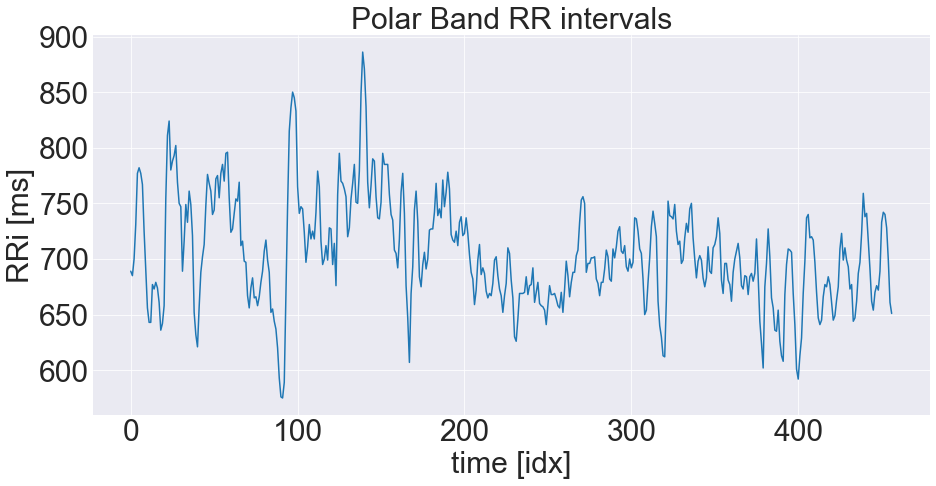

In [93]:
plt.title("Polar Band RR intervals",fontsize = 30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel("time [idx]",fontsize = 30), plt.ylabel("RRi [ms]",fontsize = 30)
plt.plot(polar_t_bpm_rr['rr'])

# Outlier Removal - hrvanalysis tools

In [94]:
# This remove outliers from signal
rr_intervals_without_outliers = remove_outliers(rr_intervals=polar_t_bpm_rr['rr'],  low_rri=300, high_rri=2000)
# This replace outliers nan values with linear interpolation
interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers, interpolation_method="linear")

# This remove ectopic beats from signal
nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")
# This replace ectopic beats nan values with linear interpolation
interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)

time_domain_features = get_time_domain_features(interpolated_nn_intervals)

0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.


([<matplotlib.axis.XTick at 0x1c38d66610>,
 <a list of 16 Text xticklabel objects>)

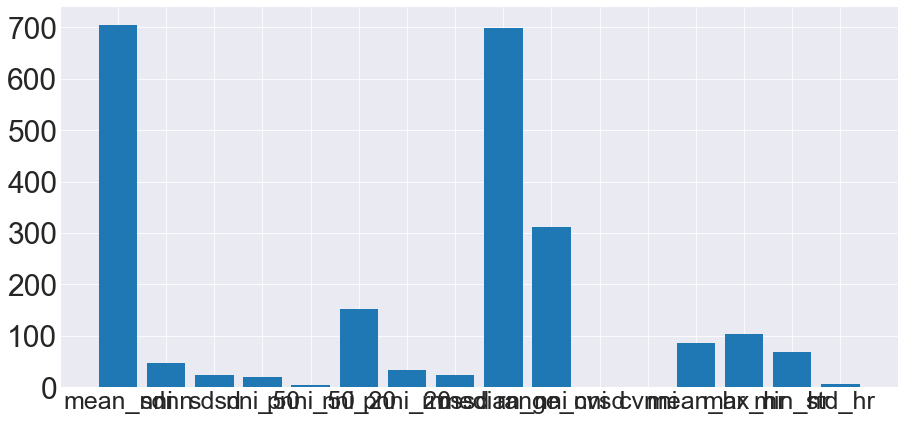

In [95]:
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 30)
plt.bar(range(len(time_domain_features)), list(time_domain_features.values()), align='center')
plt.xticks(range(len(time_domain_features)), list(time_domain_features.keys()))

### Statistical measures derived from HR (Sanity check and/or compare subjects) 
<img src="img/hrvtools_bar.png" width=600)>

# HR Frequency Analysis (LF/HF Indicator for workload)

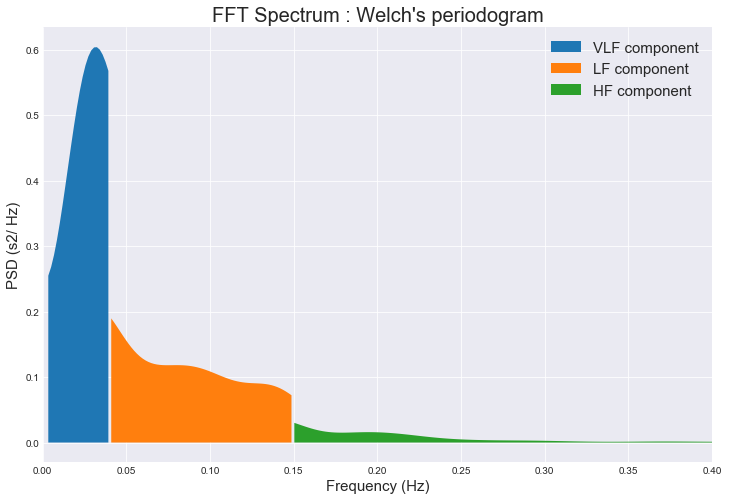

In [96]:
plot_psd(interpolated_nn_intervals, method="welch")

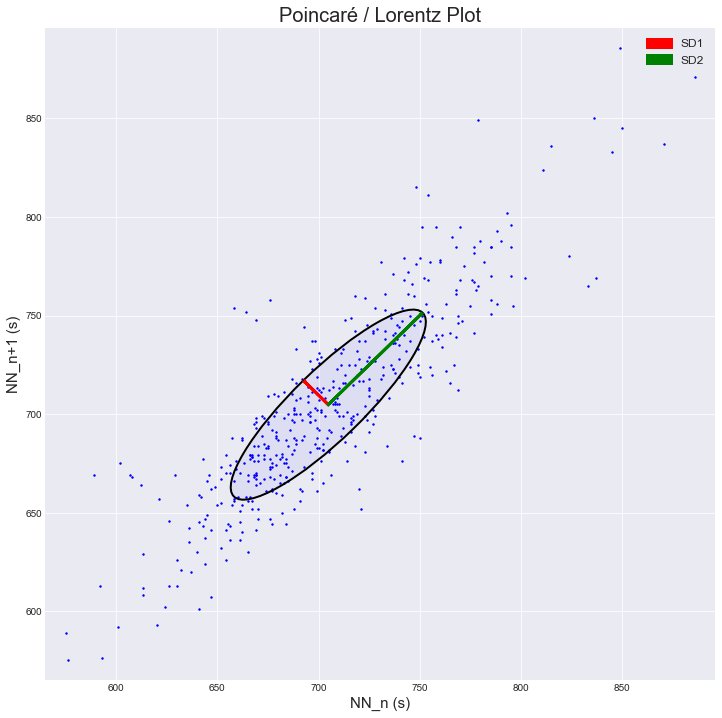

In [97]:
plot_poincare(interpolated_nn_intervals, plot_sd_features=True)

### Poincare Plots not in s but ms! ^
The transverse axis (T - green) reflects beat-to-beat variation
the longitudinal axis (L - red) reflects the overall fluctuation

# Different Sensors and their integration (Polar + Biopac)

In [98]:
rri = interpolated_rr_intervals
results = time_domain(rri)
print(results)

rriBioIn = [i * 1000 for i in list(df['CH41'])] #rr_intervals_bio
rriBio = remove_outliers(rr_intervals=rriBioIn,  low_rri=300, high_rri=2000)
# This replace outliers nan values with linear interpolation
rri_interpol_bio = interpolate_nan_values(rr_intervals=rriBio, interpolation_method="linear")
rri_interpol_bio = np.asarray(rri_interpol_bio)
tmp = rri_interpol_bio[np.logical_not(np.isnan(rri_interpol_bio))]
rri_interpol_bio = tmp.tolist()
results = time_domain(rri_interpol_bio)
print(results)

{'rmssd': 23.874764626377207, 'sdnn': 47.79455456476181, 'nn50': 21, 'pnn50': 4.595185995623632, 'mrri': 704.8052516411378, 'mhr': 85.51534712327309}
1327 outlier(s) have been deleted.
The outlier(s) value(s) are : [301595000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

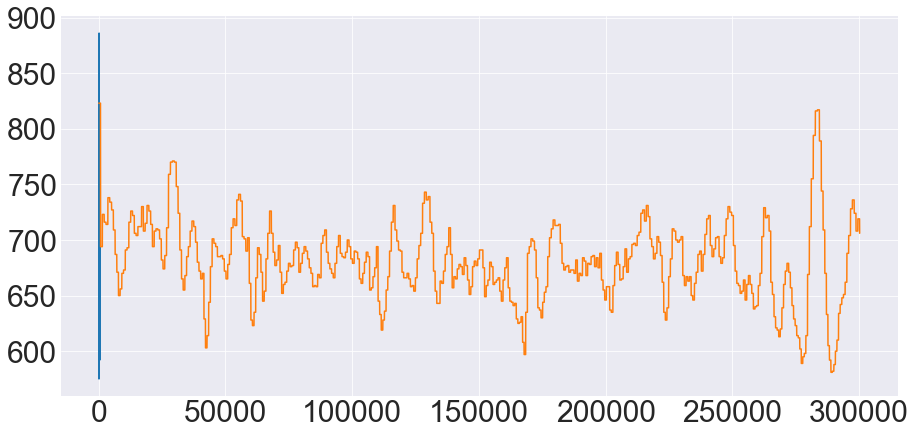

In [99]:
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.plot(rri)
plt.plot(rri_interpol_bio)

# Houston, we have a problem: 
## different sample rates..

# Dynamic Time Warping
<img src="img/DTW.png" width=600)>

/Users/kaufmann/anaconda3/envs/bh/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning:

divide by zero encountered in true_divide

/Users/kaufmann/anaconda3/envs/bh/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning:

invalid value encountered in multiply



/Users/kaufmann/anaconda3/envs/bh/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/Users/kaufmann/anaconda3/envs/bh/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



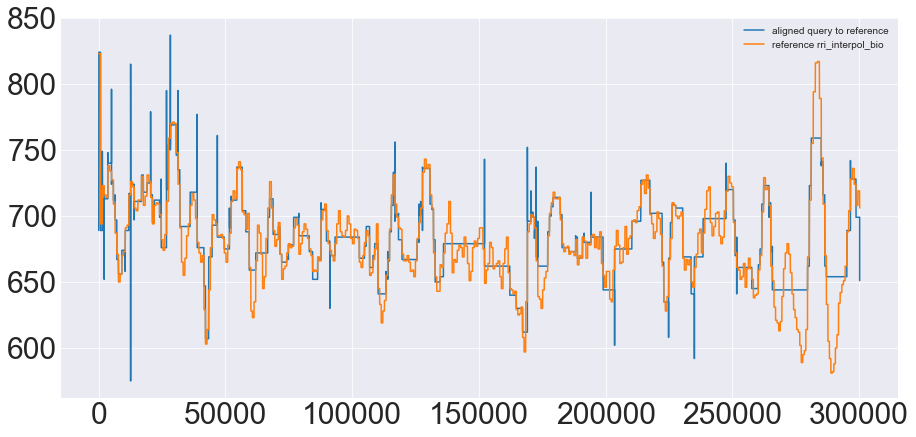

In [100]:
x = np.array(rri)
y = np.array(rri_interpol_bio)
res = dtw(x, y)
print(res)
# warp x to y
x_warping_path = res.get_warping_path(target="query")
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.plot(x[x_warping_path], label="aligned query to reference")
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.plot(y, label="reference rri_interpol_bio")
plt.legend()

<img src="img/yoda.png" width=600>

# Pupillometry

In [101]:
def remove_adjacent(list_in):
  a = []
  for item in list_in:
    if len(a):
      if a[-1] != item:
        a.append(item)
    else: a.append(item)        
  return a

In [102]:
fileNamePupil = '/Users/kaufmann/ecg_pupillometry_pipeline_kaufmann/data/M/_slash_pupil_info.csv'
df_pupil=pd.read_csv(fileNamePupil)

rri_interpol_bio_clean = remove_adjacent(rri_interpol_bio)
rri_interpol_bio_clean_ms = [i / 1000 for i in rri_interpol_bio_clean]

# Rolling Correlation between Pupil Diameter and Polar RRi

In [103]:
windowsize = 30
c2 = df_pupil['diameter'].rolling(windowsize).corr(polar_t_bpm_rr['rr'].interpolate(method='index'))

In [104]:
thresh_low =15 # pupil diameter in px (pupil labs cam)
thresh_up =50

df_pupil['diameter_thresh'] = df_pupil['diameter'].copy()
#add nans lower than thresh
df_pupil['diameter_thresh'][df_pupil['diameter_thresh'] < thresh_low] = np.nan
df_pupil['diameter_thresh'][df_pupil['diameter_thresh'] > thresh_up] = np.nan
df_pupil['diameter_thresh_median'] = scipy.signal.medfilt(df_pupil['diameter_thresh'], kernel_size=31)
#df_pupil['diameter_thresh_median'] = df_pupil['diameter_thresh_median'].interpolate()

#More Filtering
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


order = 6
fs = 160.0       # sample rate, Hz
cutoff = 1  # desired cutoff frequency of the filter, Hz
filtered_diameter = butter_lowpass_filter(df_pupil['diameter_thresh_median'], cutoff, fs, order)
filtered_diameter = df_pupil['diameter_thresh_median'] - median(df_pupil['diameter_thresh_median'])

df_corr=pd.DataFrame(polar_t_bpm_rr['rr'][0:435].astype(int))
df_corr['bio_rr']=pd.DataFrame(rri_interpol_bio_clean)



/Users/kaufmann/anaconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/kaufmann/anaconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/kaufmann/anaconda3/envs/bh/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning:

Invalid value encountered in median



In [105]:
#import chart_studio.plotly as py # ONLINE TOOL, BUT WANT OFFLINE
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go

init_notebook_mode(connected=True) 



trace1 = (go.Scatter(x=df_pupil['rosbagTimestamp'], y=df_pupil['diameter_thresh_median'], name="Pupil Diameter Filtered [px]",
                         line_color='deepskyblue'))
    
trace2 = go.Scatter(x=polar_t_bpm_rr['rosbagTimestamp'], y=polar_t_bpm_rr['rr'], name="Polar RR Intervals [ms]",
                         line_color='red')
trace3 = (go.Scatter(x=df_pupil['rosbagTimestamp'], y=df_pupil['diameter'], name="Pupil Diameter Unfiltered [px]",
                         line_color='blue'))

trace4 = go.Scatter( y=c2, name="Correlation",
                         line_color='teal')
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    title='Multi y-axes with Physiological Data',
    width=1200,
    xaxis=dict(
        domain=[0.3, 0.7]
    ),
    yaxis=dict(
        title='Pupil Diameter [px]',
        titlefont=dict(
            color='#1f77b4'
        ),
        tickfont=dict(
            color='#1f77b4'
        )
    ),
    yaxis2=dict(
        title='RR Intervals [ms]',
        titlefont=dict(
            color='#ff7f0e'
        ),
        tickfont=dict(
            color='#ff7f0e'
        ),
        anchor='free',
        overlaying='y',
        side='left',
        position=0.15
    ),
    yaxis3=dict(
        title='Pupil Diameter [px]',
        titlefont=dict(
            color='blue'
        ),
        tickfont=dict(
            color='blue'
        ),
        anchor='x',
        overlaying='y',
        side='right'
    ),
    yaxis4=dict(
        title='Correlation',
        titlefont=dict(
            color='#9467bd'
        ),
        tickfont=dict(
            color='#9467bd'
        ),
        anchor='free',
        overlaying='y',
        side='right',
        position=0.85
    )
)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(title_text='Multi data with Rangeslider',
                  xaxis_rangeslider_visible=True)
fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(
            active=0,
            buttons=list([
                dict(label="Pupil Raw",
                     method="update",
                     args=[{"visible": [False, False, True, False]},
                           {"title": "Pupil Raw",
                            "annotations": []}]),
                dict(label="Pupil Filtered",
                     method="update",
                     args=[{"visible": [True, False, False, False]},
                           {"title": "Pupil blinking and outliers filtered",
                            "annotations": []}]),
                dict(label="Pupil Filt. + RRi",
                     method="update",
                     args=[{"visible": [True, False, True, False]},
                           {"title": "Pupil Filt. + RRi",
                            "annotations": []}]),
                dict(label="Correlation",
                     method="update",
                     args=[{"visible": [False, False, False, True]},
                           {"title": "Correlation",
                            "annotations": []}]),
            ]),
        )
    ])
iplot(fig, filename='multiple-axes-multiple')

# Resume
<img src="img/overview.png" width=900>



# Tools I used (successfully)

* *Anaconda* (s)
* *Docker* (0.7*s) -> is a bit behind compared to current local version
* *Pandas* (s)
* NeuroKit (f) -> Differs from Documentation, Issue exists
* *Ipython Notebooks* (s)
# Plus

* Plotly (s)
* Tedious dash experience (0.5*s)

# Pretty Brain Image Incoming
<img src="img/prettyBrain1.png" width=600>

<img src="img/prettyBrain2.png" width=600>

https://phys.org/news/2019-08-brain-mini-brains-grown-dish.html
A cross-section of a brain organoid, showing the initial formation of a cortical plate. Each color marks a different type of brain cell. Credit: Muotri Lab/UCTV
    
    